# [kaggleのタイタニック]

- カーネルを参考に一旦最後まで解析を実施

## 1. 入力

 ### 1.1 必要なライブラリなどをインポートする

In [4]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt

from collections import Counter

import re

# jupyter-notebookに描画する
%matplotlib inline

### 1.2 入力データを読み込む

In [5]:
# csvを読み込み、文字の変換を行う
titanic_df= pd.read_csv("./input/train.csv")

test_df= pd.read_csv("./input/test.csv")
IDtest = test_df["PassengerId"]

titanic_df.info()
titanic_df.head()
titanic_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 1.3 one-hot エンコーディング

In [6]:
# Sexを値に置換
titanic_df['Sex'] =titanic_df['Sex'].replace('male',1).replace('female',2)
test_df['Sex'] =test_df['Sex'].replace('male',1).replace('female',2)

# Embarkedにを値に置換
titanic_df['Embarked']=titanic_df['Embarked'].replace('S',1).replace('C',2).replace('Q',3)
test_df['Embarked']=test_df['Embarked'].replace('S',1).replace('C',2).replace('Q',3)

titanic_df['Embarked']=titanic_df['Embarked'].fillna(1)



In [7]:
'''
 Yassine Ghouzamさんが作成したノートブックを参考に[Age]を削除
'''

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        # Q1 = np.percentile(df[col], 25)
        Q1 = df[col].describe()['25%']
        # 3rd quartile (75%)
        #Q3 = np.percentile(df[col],75)
        Q3 = df[col].describe()['75%']
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
               
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(titanic_df,0,["Age"])

titanic_df.loc[Outliers_to_drop] # Show the outliers rows

titanic_df = titanic_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## 3. 欠損値の対処

### 3.1 欠損に対処

In [8]:
# 解析するためにtestデータもくっつける
vtrain_len = len(titanic_df)
dataset_df =  pd.concat(objs=[titanic_df, test_df], axis=0).reset_index(drop=True)

# 後ほど復元するためにサイズを保存
titanic_len = len(titanic_df)

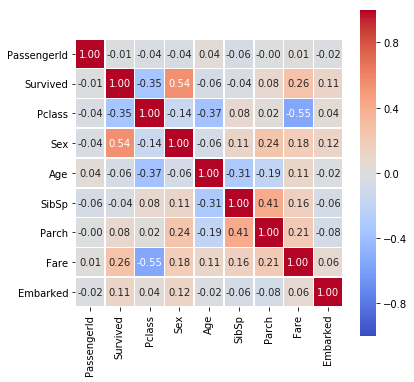

In [9]:
corrmat = titanic_df.corr()
plt.subplots(figsize=(6,6))
sns.heatmap(corrmat, vmax=1,vmin=-1, square=True, annot=True, fmt='1.2f',linewidths=.5,cmap='coolwarm',center=0)

In [10]:
# Age
# Ageが欠損しているデータについて、SibSP, Parch, Pclassが等しいデータを探して平均値をとる

index_NaN_age = list(dataset_df["Age"][dataset_df["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset_df["Age"].median()
    age_pred = dataset_df["Age"][((dataset_df['SibSp'] == dataset_df.iloc[i]["SibSp"]) & (dataset_df['Parch'] == dataset_df.iloc[i]["Parch"]) & (dataset_df['Pclass'] == dataset_df.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset_df['Age'].iloc[i] = age_pred
    else :
        dataset_df['Age'].iloc[i] = age_med


/home/hide/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def transform_features(df):
    df = simplify_ages(df)
    return df

titanic_df = transform_features(titanic_df)
test_df = transform_features(test_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,Student,1,0,A/5 21171,7.2500,NaN,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,Adult,1,0,PC 17599,71.2833,C85,2.0
2,3,1,3,"Heikkinen, Miss. Laina",2,Young Adult,0,0,STON/O2. 3101282,7.9250,NaN,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,Young Adult,1,0,113803,53.1000,C123,1.0
4,5,0,3,"Allen, Mr. William Henry",1,Young Adult,0,0,373450,8.0500,NaN,1.0


In [12]:
# Nameに入っている　「Mr.」等を Salutation列を作って入れる

Title=pd.DataFrame([i.split(', ')[1].split('.')[0] for i in dataset_df['Name']])

dataset_df['Title'] = Title

dataset_df.head()

combine =[dataset_df]

Title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4} 
for dataset_df in combine:
        dataset_df['Title'] = dataset_df['Title'].map(Title_mapping) 
        dataset_df['Title'] = dataset_df['Title'].fillna(0)

dataset_df.drop(labels = ["Name"], axis = 1, inplace = True)

In [13]:
dataset_df.drop(labels = ["Ticket"], axis = 1, inplace = True)
dataset_df.drop(labels = ["Cabin"], axis = 1, inplace = True)

In [14]:
# NULL値を補正
dataset_df['Fare'].fillna(dataset_df.Pclass.median(),inplace=True)

In [15]:
# Apply log to Fare to reduce skewness distribution
dataset_df["Fare"] = dataset_df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [16]:
combine=[dataset_df]
dataset_df["FamilySize"] = dataset_df["SibSp"] + dataset_df["Parch"] + 1
for dataset_df in combine:
    dataset_df['IsAlone'] = 0
    dataset_df.loc[dataset_df['FamilySize'] == 1, 'IsAlone'] = 1

In [17]:
titanic_df=dataset_df[:titanic_len]
test_df=dataset_df[titanic_len:]
test_df.drop(labels=["Survived"],axis = 1,inplace=True)

titanic_df["Survived"] = titanic_df["Survived"].astype(int)

Y_train = titanic_df["Survived"]

X_train = titanic_df.drop(labels = ["Survived"],axis = 1)


/home/hide/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hide/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [19]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, Y_train)
predictions = gbm.predict(test_df)

submission = pd.DataFrame({ 'PassengerId': test_df['PassengerId'],
                            'Survived': predictions })
submission.to_csv("submission.csv", index=False)

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [25]:
# Gradient boosting tunning
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,RandomizedSearchCV
XGBx = xgb.XGBClassifier()

param         = {'n_estimators'    : [100,200,300],
                 'learning_rate'   : [0.1, 0.05, 0.01],
                 'max_depth'       : [1,4, 8],
                 'min_child_weight': [1,5,10]
              }
# トレーニングデータと訓練データに分ける
kfold = StratifiedKFold(n_splits=10)

rsXGB = RandomizedSearchCV(XGBx,param_distributions = param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

rsXGB.fit(X_train,Y_train)

XGB_best = rsXGB.best_estimator_

# Best score
rsXGB.best_score_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Depre

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hide/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

NameError: name 'rsXBG' is not defined

In [26]:
rsXGB.best_score_

0.8306818181818182